# Modelo 1: recomendação de ofertas

## *Etapa 1: Modelo Supervisionado*

Esta etapa inclui o treinamento do modelo supervisionado que tem como resultado a propensão de compra de um tipo de oferta $P(offerType)$ 
assim como  a propensão de compra de uma oferta condicionada ao tipo de oferta $P(offer | offerType)$ 


TEOREMA DE BAYES

$$P(A|B) = \frac{P(B|A) \times P(A)}{P(B)}$$

PARA -> 
A = offer,
B = offer_type

$$P(offer | offerType) = \frac{P(offerType | offer) \times P(offer)}{P(offerType)}$$

$$P(offer | offerType) \times P(offerType) = P(offerType | offer) \times P(offer)$$

$$P(offer) = \frac{P(offer | offerType) \times P(offerType)}{P(offerType | offer)}$$


$$P(offerType | offer) = 1$$

SOLUÇÂO:
$$P(offer) = P(offer | offerType) \times P(offerType)$$

$P(offer | offerType) =>$ Solução Frequentista

$P(offerType) =>$ Modelo Supervisionado

## *Etapa 2: Cluster de Clientes*
Esta etapa inclui a criação de cluster de clientes com base em suas informações demograficas

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('PySparkTest').getOrCreate()

from IPython.display import display, HTML
display(HTML("<style>.jp-Cell-outputArea { text-align: center; }</style>"))

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/11 00:24:10 WARN Utils: Your hostname, N0L144853, resolves to a loopback address: 127.0.1.1; using 192.168.68.107 instead (on interface wlp0s20f3)
25/08/11 00:24:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/11 00:24:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/08/11 00:24:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/08/11 00:24:11 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/08/11 00:24:11 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/08/11 00:24:11 WARN Util

In [2]:
import plotly.express as px
from pyspark.sql import functions as F
from pyspark.ml.clustering import KMeans
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler


def metrics_at(df, tresh):
    TN = df.where(f"y_proba_class1 < {tresh} AND target=0").count()
    FN = df.where(f"y_proba_class1 < {tresh} AND target=1").count()
    FP = df.where(f"y_proba_class1 >= {tresh} AND target=0").count()
    TP = df.where(f"y_proba_class1 >= {tresh} AND target=1").count()

    precision = TP / (TP + FP) if (TP + FP)>0 else 0.0
    recall = TP / (TP + FN) if (TP + FN)>0 else 0.0
    f1 = (2*precision*recall)/(precision+recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1, TP, FP, TN, FN

def optimize_threshold(df):
    qs = [i/100 for i in range(5, 96)]
    thresholds = df.approxQuantile("y_proba_class1", qs, 0.001)

    best = (None, -1.0) 
    for t in thresholds:
        p,r,f1,TP,FP,TN,FN = metrics_at(df, t)
        if f1 > best[1]:
            best = (t, f1)
    best_t = best[0]

    return best_t

SPLIT_TRAIN = 0.8
NUM_TREES = 200
MAX_DEPTH = 10
MAX_BINS = 80

# Read Files

In [3]:
path_mastertable = '../data/trusted/mastertable'
path_output_freq_bayes = '../data/trusted/freq_bayes'
path_output_rf_model = '../data/trusted/rf_output_model'
path_output_km_model = '../data/trusted/km_output_model'

df_merge = spark.read.format("parquet").option("header", "true").option("inferSchema", "true").load(path_mastertable)

# Modeling

In [4]:
aux = df_merge.select("client_id", 'offer_id', "qtd_offer_received", 'qtd_offer_completed', 'offer_type')\
              .groupBy("client_id", 'offer_type')\
              .agg(F.sum("qtd_offer_received").alias("offer_type_count"))

aux.show(5, truncate=False)

+--------------------------------+-------------+----------------+
|client_id                       |offer_type   |offer_type_count|
+--------------------------------+-------------+----------------+
|00bc983061d3471e8c8e74d31b7c8b6f|discount     |2               |
|0222d267445f4f078bc325224e471766|bogo         |2               |
|03118ab70a404fada1a433cd6abaa491|bogo         |1               |
|033d0a511a5c452ea2be37a23f8c6dcb|informational|2               |
|072731be403a472883bed6c38a8e7aa8|bogo         |1               |
+--------------------------------+-------------+----------------+
only showing top 5 rows


In [5]:
df_freq_bayes = df_merge.select("client_id", 'offer_id', 'qtd_offer_completed', 'offer_type')\
                        .join(aux, on=['client_id', 'offer_type'], how='left')\
                        .select("client_id", "offer_type", "offer_id", "qtd_offer_completed", "offer_type_count")\
                        .withColumn("freq_bayes", F.when(F.col("offer_type_count")!=0, F.col("qtd_offer_completed")/F.col("offer_type_count")).otherwise(0))\
                        .orderBy("client_id", 'offer_id')
df_freq_bayes.show(truncate=False)

+--------------------------------+-------------+--------------------------------+-------------------+----------------+------------------+
|client_id                       |offer_type   |offer_id                        |qtd_offer_completed|offer_type_count|freq_bayes        |
+--------------------------------+-------------+--------------------------------+-------------------+----------------+------------------+
|0009655768c64bdeb2e877511632db8f|discount     |2906b810c7d4411798c6938adc9daaa5|1                  |2               |0.5               |
|0009655768c64bdeb2e877511632db8f|informational|3f207df678b143eea3cee63160fa8bed|0                  |2               |0.0               |
|0009655768c64bdeb2e877511632db8f|informational|5a8bc65990b245e5a138643cd4eb9837|0                  |2               |0.0               |
|0009655768c64bdeb2e877511632db8f|bogo         |f19421c1d4aa40978ebb69ca19b0e20d|1                  |1               |1.0               |
|0009655768c64bdeb2e877511632db8f|

In [6]:
df_freq_bayes.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_freq_bayes.columns]).show()

+---------+----------+--------+-------------------+----------------+----------+
|client_id|offer_type|offer_id|qtd_offer_completed|offer_type_count|freq_bayes|
+---------+----------+--------+-------------------+----------------+----------+
|        0|         0|       0|                  0|               0|         0|
+---------+----------+--------+-------------------+----------------+----------+



In [7]:
df_freq_bayes.write.format("parquet").mode("overwrite").save(path_output_freq_bayes)

## Select Features

In [8]:
df_features = df_merge.select('client_id', 'offer_id', 'offer_type_index', 'qtd_offer_received', 'qtd_offer_viewed', 'qtd_offer_completed', 'sum_reward', 
                              'registered_duration_month', 'registered_duration_years', 'gender_M', 'gender_F', 'gender_O','gender_U', 'age_group_index', 
                              'credit_card_limit', 'category_limite', 'offer_min_value', 'offer_discount_value', 'offer_duration', 'qtd_transaction', 
                              'total_amount', 'avg_amount')\
                        .withColumn('target', F.when(F.col('qtd_offer_completed')>0, 1).otherwise(0))\
                        .drop('qtd_offer_completed')
df_features.show(5, truncate=False)

+--------------------------------+--------------------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------+----------+------+
|client_id                       |offer_id                        |offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|total_amount|avg_amount|target|
+--------------------------------+--------------------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------

In [9]:
df_features.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|28996|
|     0|34292|
+------+-----+



## Create RandomForestModel

In [10]:
features = ['offer_type_index',  'offer_min_value', 'offer_discount_value', 'offer_duration', 'gender_M', 
            'gender_F', 'gender_O', 'gender_U', 'age_group_index','category_limite', 'registered_duration_month',
            'registered_duration_years', 'qtd_transaction', 'total_amount', 'avg_amount']

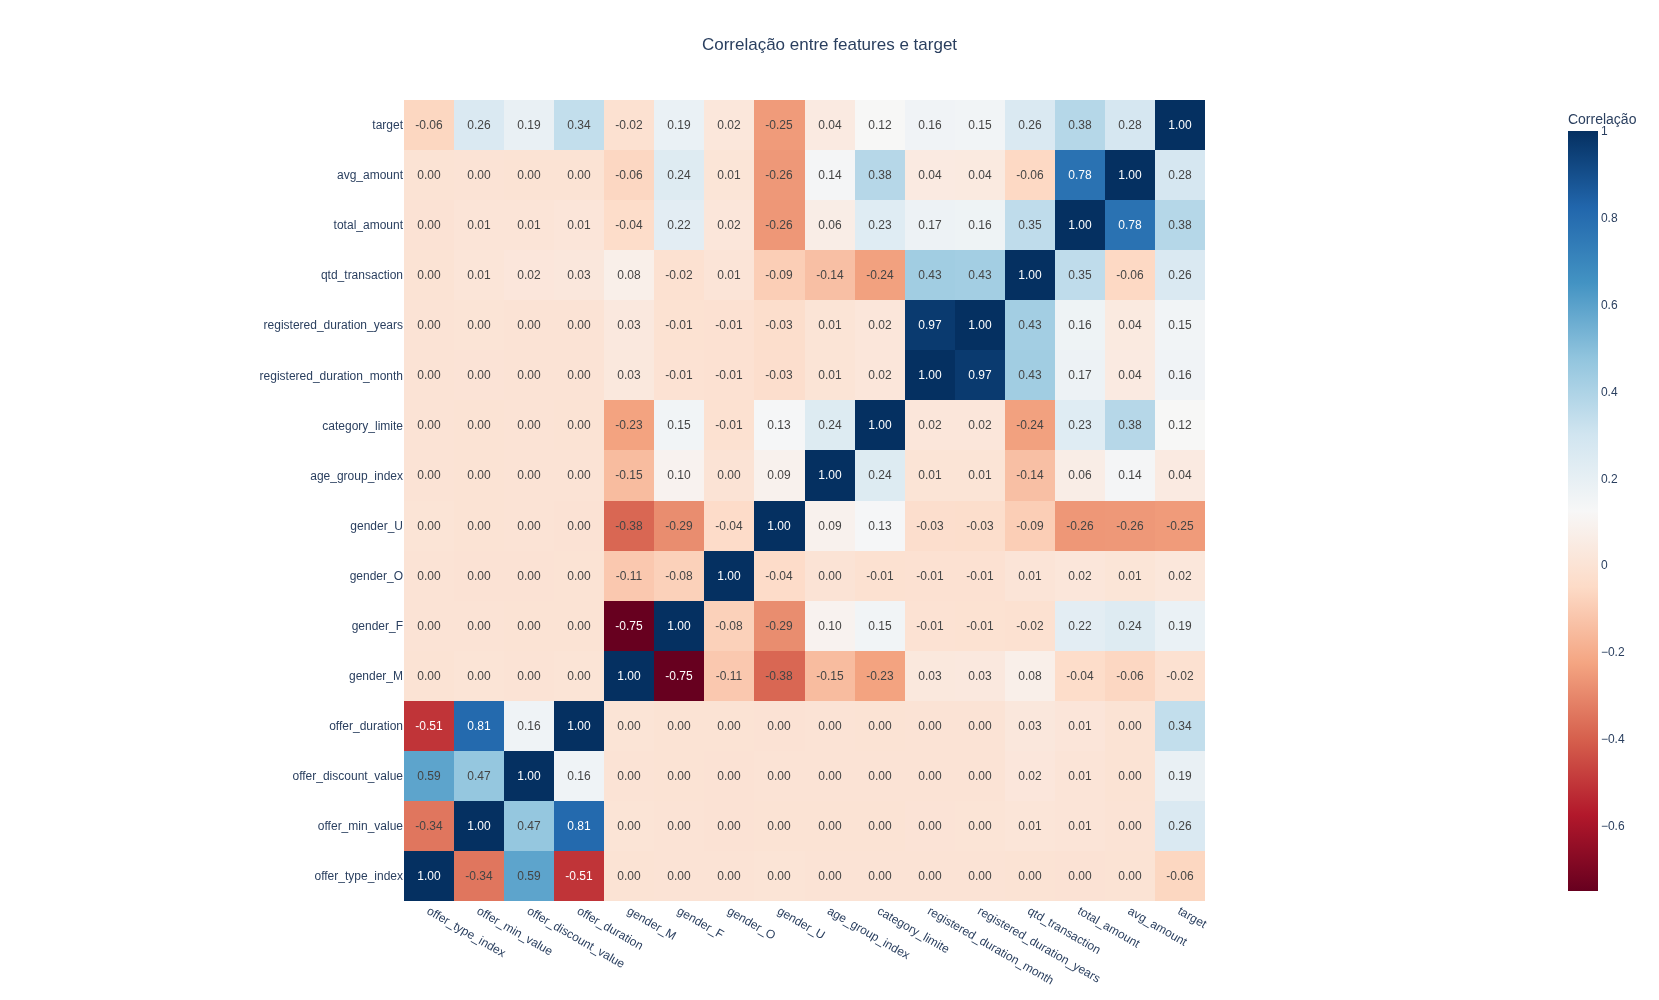

In [11]:
correlation_matrix = df_features[features + ['target']].toPandas().corr()

fig = px.imshow(
    correlation_matrix,
    text_auto=".2f",           
    color_continuous_scale="RdBu",  
    origin="lower",
    title="Correlação entre features e target"
)

fig.update_layout(
    width=1500,
    height=1000,
    title=dict(x=0.5, xanchor="center"), 
    coloraxis_colorbar=dict(title="Correlação")
)

fig.show()

### Train Model

In [12]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_features = assembler.transform(df_features)

train_df, test_df = df_features.randomSplit([SPLIT_TRAIN, 1-SPLIT_TRAIN], seed=42)

In [13]:
df_features.count(), train_df.count()+test_df.count()

25/08/11 00:24:20 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


(63288, 63288)

In [14]:
rf = RandomForestClassifier(labelCol="target", 
                            featuresCol="features", 
                            numTrees=NUM_TREES, 
                            maxDepth=MAX_DEPTH, 
                            maxBins=MAX_BINS
                        )
model = rf.fit(train_df)

25/08/11 00:24:29 WARN DAGScheduler: Broadcasting large task binary with size 1135.3 KiB
25/08/11 00:24:32 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/08/11 00:24:35 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/08/11 00:24:39 WARN DAGScheduler: Broadcasting large task binary with size 1073.3 KiB
25/08/11 00:24:39 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
25/08/11 00:24:44 WARN DAGScheduler: Broadcasting large task binary with size 1869.8 KiB
25/08/11 00:24:44 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
25/08/11 00:24:50 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


In [15]:
pred = model.transform(test_df)

In [16]:
pred = pred.withColumn("prob_vec", vector_to_array(F.col("probability")))\
           .withColumn("y_proba_class0", F.col("prob_vec")[0])\
           .withColumn("y_proba_class1", F.col("prob_vec")[1])

In [17]:
conf_matrix_df = pred.select("target", "prediction")\
                     .crosstab("target", "prediction").fillna(0)
conf_matrix_df.show()

25/08/11 00:24:52 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:24:53 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:24:53 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:24:53 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:24:54 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:24:55 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


+-----------------+----+----+
|target_prediction| 0.0| 1.0|
+-----------------+----+----+
|                0|5979| 979|
|                1| 610|5245|
+-----------------+----+----+



25/08/11 00:24:55 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


##### Podemos melhorar um pouco esses Falsos Negativo encontrando um melhor ponto de corte (Temos que ter atenção, pois mudar isso vai depender do negócio, em outras palavras, da estratégia de negócio)
 - Vale a pena pro negócio enviar mais ofertas que tenham uma baixa probabilidade de aceitação sabendo que vamos capturar mais clientes com alta probabilidade de aceitação?

##### Procurando melhor Tresh para a base de Teste

In [18]:
pred_probs = pred.select('y_proba_class1', 'target')
test_best_tresh = optimize_threshold(pred_probs)

print(f"Melhor threshold por F1: {test_best_tresh:.3f}")

25/08/11 00:24:55 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:24:56 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:24:57 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:24:58 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:25:00 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:25:01 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:25:02 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:25:02 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:25:03 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:25:04 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:25:05 WARN DAGScheduler: Broadcasting larg

Melhor threshold por F1: 0.456


In [19]:
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred.select('y_proba_class1', 'target'), test_best_tresh)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/11 00:29:53 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:29:54 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:29:55 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:29:55 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


5879 1079 517 5338
precision: 0.83185
recall: 0.91170
f1: 0.86995


### Predict Dataset

In [20]:
df_base = assembler.transform(df_features.drop('features'))

preds_base = model.transform(df_base)

preds_base = preds_base.withColumn("prob_vec", vector_to_array(F.col("probability")))\
                       .withColumn("y_proba_class0", F.col("prob_vec")[0])\
                       .withColumn("y_proba_class1", F.col("prob_vec")[1])

In [21]:
preds_base.show()

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------------+------------------+------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+-------------------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|      total_amount|        avg_amount|target|            features|       rawPrediction|         probability|prediction|            prob_vec|      y_proba_class0|     y_proba_class1|
+---------

25/08/11 00:29:56 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


In [22]:
conf_matrix_df = preds_base.select("target", "prediction")\
                           .crosstab("target", "prediction").fillna(0)
conf_matrix_df.show()

25/08/11 00:29:57 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:29:59 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:29:59 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:29:59 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:00 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:01 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


+-----------------+-----+-----+
|target_prediction|  0.0|  1.0|
+-----------------+-----+-----+
|                0|29674| 4618|
|                1| 2803|26193|
+-----------------+-----+-----+



25/08/11 00:30:02 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


##### Verificando precision, recall e f1 para a base toda com o Tresh padrão

In [23]:
pred_probs = preds_base.select('y_proba_class1', 'target')
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred_probs, 0.5)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/11 00:30:02 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:04 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:06 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:07 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


29674 4618 2803 26193
precision: 0.85012
recall: 0.90333
f1: 0.87592


##### Verificando precision, recall e f1 para a base toda com o melhor Tresh da base de Teste

In [24]:
pred_probs = preds_base.select('y_proba_class1', 'target')
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred_probs, test_best_tresh)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/11 00:30:09 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:11 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:12 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:14 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


29164 5128 2372 26624
precision: 0.83850
recall: 0.91820
f1: 0.87654


##### Procurando melhor Tresh quando considerado toda a base

In [25]:
pred_probs = preds_base.select('y_proba_class1', 'target')
dataset_best_tresh = optimize_threshold(pred_probs)

print(f"Melhor threshold por F1: {dataset_best_tresh:.3f}")

25/08/11 00:30:16 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:18 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:20 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:21 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:23 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:25 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:27 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:29 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:30 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:34 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:30:36 WARN DAGScheduler: Broadcasting larg

Melhor threshold por F1: 0.459


In [26]:
pred_probs = preds_base.select('y_proba_class1', 'target')
precision, recall, f1, TP, FP, TN, FN = metrics_at(pred_probs, dataset_best_tresh)

print(TN, FP, FN, TP)
print(f"precision: {precision:.5f}")
print(f"recall: {recall:.5f}")
print(f"f1: {f1:.5f}")

25/08/11 00:41:30 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:41:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:41:34 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/08/11 00:41:35 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


29195 5097 2386 26610
precision: 0.83925
recall: 0.91771
f1: 0.87673


In [27]:
preds_base.count(), df_features.count()

(63288, 63288)

In [28]:
preds_base.show(5)

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------+----------+------+--------------------+--------------------+--------------------+----------+--------------------+-------------------+------------------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|total_amount|avg_amount|target|            features|       rawPrediction|         probability|prediction|            prob_vec|     y_proba_class0|    y_proba_class1|
+--------------------+--------------------

25/08/11 00:41:37 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


In [29]:
preds_base.write.format("parquet").mode("overwrite").save(path_output_rf_model)

25/08/11 00:41:38 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


## Create KMeansModel

In [30]:
features = ['registered_duration_month', 'registered_duration_years', 'gender_M', 'gender_F', 'gender_O','gender_U', 'age_group_index', 
            'credit_card_limit', 'category_limite', 'qtd_transaction', 'total_amount', 'avg_amount']

In [31]:
correlation_matrix = df_features[features + ['target']].toPandas().corr()

fig = px.imshow(
    correlation_matrix,
    text_auto=".2f",           
    color_continuous_scale="RdBu",  
    origin="lower",
    title="Correlação entre features e target"
)

fig.update_layout(
    width=1500,
    height=1000,
    title=dict(x=0.5, xanchor="center"), 
    coloraxis_colorbar=dict(title="Correlação")
)

fig.show()

In [32]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_features_kmeans = assembler.transform(df_features.drop('features'))

In [33]:
scaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=True)
df_features_kmeans = scaler.fit(df_features_kmeans).transform(df_features_kmeans)

In [34]:
df_features_kmeans.show(5)

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------+----------+------+--------------------+--------------------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|total_amount|avg_amount|target|            features|     features_scaled|
+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+---------------

In [35]:
kmeans = KMeans(featuresCol="features_scaled", predictionCol="cluster", k=5, seed=42)
model_kmeans = kmeans.fit(df_features_kmeans)

In [36]:
df_clusters = model_kmeans.transform(df_features_kmeans)

In [37]:
df_clusters.show()

+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+--------+--------+---------------+-----------------+---------------+---------------+--------------------+--------------+---------------+------------------+------------------+------+--------------------+--------------------+-------+
|           client_id|            offer_id|offer_type_index|qtd_offer_received|qtd_offer_viewed|sum_reward|registered_duration_month|registered_duration_years|gender_M|gender_F|gender_O|gender_U|age_group_index|credit_card_limit|category_limite|offer_min_value|offer_discount_value|offer_duration|qtd_transaction|      total_amount|        avg_amount|target|            features|     features_scaled|cluster|
+--------------------+--------------------+----------------+------------------+----------------+----------+-------------------------+-------------------------+--------+--------+-----

In [38]:
df_clusters.write.format("parquet").mode("overwrite").save(path_output_km_model)